Model score: 

Mean absolute error score: Compares the absolute difference bewteen the original and predicted values.

Mean squared error score: Compares the squared difference bewteen the original and predicted values.

R2 score: Compares the 2 set's values, the higher score the better.



    MAE = mean_absolute_error(Y_val, y_pred_val)
    MSE = mean_squared_error(Y_val, y_pred_val)
    r2 = r2_score(Y_val, y_pred_val)
    
    print('Model score : {}'.format(round(model.score(X_train,Y_train),5)))
    print('MAE score : {}'.format(round(MAE,5)))
    print('MSE score : {}'.format(round(MSE,5)))    
    print('R2 score : {}'.format(round(r2,5)))

In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import math
from scipy import stats
from scipy.stats import norm, skew 
from scipy.special import boxcox1p

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

C:\Users\Hmund\Documents\Anaconda\envs\R Jup\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Read data

In [3]:
traindf_original = pd.read_csv('train.csv')
testdf_original = pd.read_csv('test.csv')

In [4]:
traindf = traindf_original.copy()
testdf = testdf_original.copy()
combine = [traindf,testdf]
data = pd.concat((traindf, testdf)).reset_index(drop=True)

In [5]:
traindf.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
testdf.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


#### Gather info on each column, figure out which columns are important.

In [7]:
trainuniq = traindf.columns.values
testuniq = testdf.columns.values

temp = set(trainuniq)
for x in testuniq:
    if x in temp:
        temp.remove(x)
temp

{'SalePrice'}

### Column details

In [8]:
info = open("data_description.txt", "r")
data = info.read()
print(data)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [9]:
traindf.columns.unique()

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [10]:
traindf.iloc[:,0:50].describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000


In [11]:
traindf.iloc[:,50:81].describe()

,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [12]:
traindf.iloc[:,0:25].describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504


In [13]:
traindf.iloc[:,25:55].describe(include=['O'])

,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual
count,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460
unique,4,4,5,6,4,4,4,6,6,6,5,2,5,4
top,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA
freq,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735


In [14]:
traindf.iloc[:,55:81].describe(include=['O'])

,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,7,5,6,3,5,5,3,3,4,4,9,6
top,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [15]:
traindf.info()
print('_'*60)
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Sale price column and skewness

In [16]:
Saleprice_og = traindf['SalePrice']
traindf['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

C:\Users\Hmund\Documents\Anaconda\envs\R Jup\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Hmund\Documents\Anaconda\envs\R Jup\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Hmund\Documents\Anaconda\envs\R Jup\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Hmund\Documents\Anaconda\

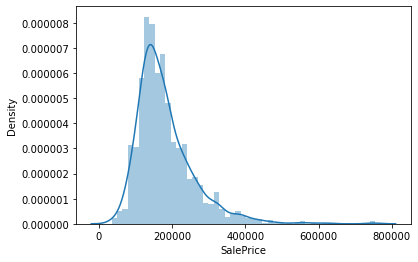

In [17]:
sns.distplot(Saleprice_og)
plt.show()

This is a positive skew

Skewness and kurtosis:

In [18]:
print(traindf['SalePrice'].skew())
print(traindf['SalePrice'].kurt())

1.8828757597682129
6.536281860064529


C:\Users\Hmund\Documents\Anaconda\envs\R Jup\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Hmund\Documents\Anaconda\envs\R Jup\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Hmund\Documents\Anaconda\envs\R Jup\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Hmund\Documents\Anaconda\

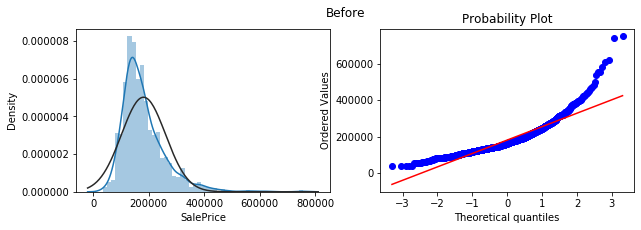

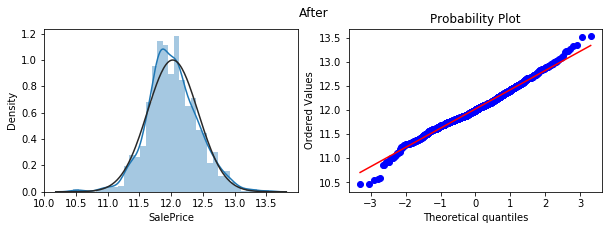

In [19]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.distplot(traindf['SalePrice'],fit=norm);
(mu, sigma) = norm.fit(traindf['SalePrice'])

plt.subplot(1,2,2)
stats.probplot(traindf['SalePrice'], plot=plt)
plt.suptitle('Before')



# Apply transformation
y_og = traindf.SalePrice.values
traindf.SalePrice = np.log1p(traindf.SalePrice )
y_train = traindf.SalePrice.values
y_train_orig = traindf.SalePrice



ig = plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.distplot(traindf['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(traindf['SalePrice'])

plt.subplot(1,2,2)
res = stats.probplot(traindf['SalePrice'], plot=plt)
plt.suptitle('After')

plt.show()


In [20]:
Saleprice_og

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [21]:
traindf.SalePrice

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1460, dtype: float64

In [22]:
combine = [traindf,testdf]

# Missing Data

##### Create table with missing value data

In [23]:
missing_table_df = pd.concat((traindf, testdf)).reset_index(drop=True)
missing_table_df
t = missing_table_df.isnull().sum().sort_values(ascending=False)
p = (missing_table_df.isnull().sum()/missing_table_df.isnull().count()).sort_values(ascending=False)
d = missing_table_df.dtypes
missing_table = pd.concat([t, p, d], axis=1, keys=['Total', 'Percent', 'Dtypes'])
missing_table.head(23)

,Total,Percent,Dtypes
PoolQC,2909,0.996574,object
MiscFeature,2814,0.964029,object
Alley,2721,0.932169,object
Fence,2348,0.804385,object
SalePrice,1459,0.499829,float64
FireplaceQu,1420,0.486468,object
LotFrontage,486,0.166495,float64
GarageQual,159,0.054471,object
GarageYrBlt,159,0.054471,float64
GarageFinish,159,0.054471,object


##### Create function to find missing values

In [24]:
def missing_values(n):
    #Input number of missing values you want to find 
    traindfnull = traindf.isnull().sum()
    testdfnull = testdf.isnull().sum()
    nullcombined = [traindfnull,testdfnull]
    for k in nullcombined:
        for x,y in k.iteritems():
            if y == n:
                print(x,y)
missing_values(1)

Electrical 1
Exterior1st 1
Exterior2nd 1
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
KitchenQual 1
GarageCars 1
GarageArea 1
SaleType 1


In [25]:
traindfnull = traindf.isnull().sum()
for x,y in traindfnull.iteritems():
    if y > 0:
        print(x,y)

LotFrontage 259
Alley 1369
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406


In [26]:
testdfnull = testdf.isnull().sum()
for x,y in testdfnull.iteritems():
    if y > 0:
        print(x,y)

MSZoning 4
LotFrontage 227
Alley 1352
Utilities 2
Exterior1st 1
Exterior2nd 1
MasVnrType 16
MasVnrArea 15
BsmtQual 44
BsmtCond 45
BsmtExposure 44
BsmtFinType1 42
BsmtFinSF1 1
BsmtFinType2 42
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
KitchenQual 1
Functional 2
FireplaceQu 730
GarageType 76
GarageYrBlt 78
GarageFinish 78
GarageCars 1
GarageArea 1
GarageQual 78
GarageCond 78
PoolQC 1456
Fence 1169
MiscFeature 1408
SaleType 1


#### Converting useless int columns to string types

In [27]:
stringval = ['MSSubClass','YrSold','MoSold']
for dataset in combine:
    for x in stringval:
        dataset[x] = dataset[x].apply(str)       

In [28]:
traindf['MSSubClass'].dtype

dtype('O')

#### Take a look at values with only 1-5 NAN types

In [29]:
missing_values(1)

Electrical 1
Exterior1st 1
Exterior2nd 1
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
KitchenQual 1
GarageCars 1
GarageArea 1
SaleType 1


In [30]:
missing_values(2)

Utilities 2
BsmtFullBath 2
BsmtHalfBath 2
Functional 2


In [31]:
missing_values(4)

MSZoning 4


In [32]:
traindf[traindf['Electrical'].isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,12.028745


In [33]:
missing_table.head(36)

,Total,Percent,Dtypes
PoolQC,2909,0.996574,object
MiscFeature,2814,0.964029,object
Alley,2721,0.932169,object
Fence,2348,0.804385,object
SalePrice,1459,0.499829,float64
FireplaceQu,1420,0.486468,object
LotFrontage,486,0.166495,float64
GarageQual,159,0.054471,object
GarageYrBlt,159,0.054471,float64
GarageFinish,159,0.054471,object


Gets rid of NA values for : 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType'

In [34]:
null_objects_one = ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'MSZoning']
for dataset in combine:
    for x in null_objects_one:
        dataset[x] = dataset[x].fillna(dataset[x].mode()[0])

In [35]:
traindf['Electrical'].unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'], dtype=object)

In [36]:
combine = [traindf, testdf]
missing_table_df = pd.concat((traindf, testdf)).reset_index(drop=True)
t = missing_table_df.isnull().sum().sort_values(ascending=False)
p = (missing_table_df.isnull().sum()/missing_table_df.isnull().count()).sort_values(ascending=False)
d = missing_table_df.dtypes
missing_table = pd.concat([t, p, d], axis=1, keys=['Total', 'Percent', 'Dtypes'])
missing_table.head(32)

,Total,Percent,Dtypes
PoolQC,2909,0.996574,object
MiscFeature,2814,0.964029,object
Alley,2721,0.932169,object
Fence,2348,0.804385,object
SalePrice,1459,0.499829,float64
FireplaceQu,1420,0.486468,object
LotFrontage,486,0.166495,float64
GarageYrBlt,159,0.054471,float64
GarageFinish,159,0.054471,object
GarageCond,159,0.054471,object


# IMPORTANT:

# Use these 2 cells to find the NAN values

Find the NA rows:

In [37]:
testdf[testdf['TotalBsmtSF'].isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
660,2121,20,RM,99.0,5940,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml


Find the values around the NA rows:

In [38]:
testdf.loc[[1115,1116,1117], ['GarageArea']]

,GarageArea
1115,0.0
1116,NaN
1117,100.0


Unique values:

In [39]:
testdf['GarageCars'].unique()

array([ 1.,  2.,  3.,  0.,  4.,  5., nan])

### For values that just need a 0 replacement:

In [40]:
null_objects_two = ['GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1','BsmtFinSF2'
           ,'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BsmtUnfSF','TotalBsmtSF']
for dataset in combine:
    for x in null_objects_two:
        dataset[x] = dataset[x].fillna(0)

In [41]:
combine = [traindf, testdf]
missing_table_df = pd.concat((traindf, testdf)).reset_index(drop=True)
t = missing_table_df.isnull().sum().sort_values(ascending=False)
p = (missing_table_df.isnull().sum()/missing_table_df.isnull().count()).sort_values(ascending=False)
d = missing_table_df.dtypes
missing_table = pd.concat([t, p, d], axis=1, keys=['Total', 'Percent', 'Dtypes'])
missing_table.head(21)

,Total,Percent,Dtypes
PoolQC,2909,0.996574,object
MiscFeature,2814,0.964029,object
Alley,2721,0.932169,object
Fence,2348,0.804385,object
SalePrice,1459,0.499829,float64
FireplaceQu,1420,0.486468,object
LotFrontage,486,0.166495,float64
GarageFinish,159,0.054471,object
GarageQual,159,0.054471,object
GarageCond,159,0.054471,object


Replace objects with 'none':

In [42]:
null_objects_three = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"PoolQC"
           ,'Alley','Fence','MiscFeature','FireplaceQu','MasVnrType','Utilities', 'MSZoning']
for dataset in combine:
    for x in null_objects_three:
        dataset[x] = dataset[x].fillna(0)

In [43]:
combine = [traindf, testdf]
missing_table_df = pd.concat((traindf, testdf)).reset_index(drop=True)
t = missing_table_df.isnull().sum().sort_values(ascending=False)
p = (missing_table_df.isnull().sum()/missing_table_df.isnull().count()).sort_values(ascending=False)
d = missing_table_df.dtypes
missing_table = pd.concat([t, p, d], axis=1, keys=['Total', 'Percent', 'Dtypes'])
missing_table.head(10)

,Total,Percent,Dtypes
SalePrice,1459,0.499829,float64
LotFrontage,486,0.166495,float64
Functional,2,0.000685,object
Foundation,0,0.000000,object
RoofMatl,0,0.000000,object
Exterior1st,0,0.000000,object
Exterior2nd,0,0.000000,object
MasVnrType,0,0.000000,object
MasVnrArea,0,0.000000,float64
ExterQual,0,0.000000,object


## We have 3 more NA columns left

### Minor fixes:

In [44]:
minorfix = ['Functional']
for dataset in combine:
    for x in minorfix:
        dataset[x] = dataset[x].fillna('Typ')           

In [45]:
combine = [traindf, testdf]
missing_table_df = pd.concat((traindf, testdf)).reset_index(drop=True)
t = missing_table_df.isnull().sum().sort_values(ascending=False)
p = (missing_table_df.isnull().sum()/missing_table_df.isnull().count()).sort_values(ascending=False)
d = missing_table_df.dtypes
missing_table = pd.concat([t, p, d], axis=1, keys=['Total', 'Percent', 'Dtypes'])
missing_table.head(5)

,Total,Percent,Dtypes
SalePrice,1459,0.499829,float64
LotFrontage,486,0.166495,float64
Foundation,0,0.000000,object
RoofMatl,0,0.000000,object
Exterior1st,0,0.000000,object


## Fix the LotFrontage column, we will leave the sale price alone

In [46]:
Lot = 'LotFrontage'
for dataset in combine:
    for Lot in dataset:
        dataset['LotFrontage'] = dataset.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
        

In [47]:
combine = [traindf, testdf]
missing_table_df = pd.concat((traindf, testdf)).reset_index(drop=True)
t = missing_table_df.isnull().sum().sort_values(ascending=False)
p = (missing_table_df.isnull().sum()/missing_table_df.isnull().count()).sort_values(ascending=False)
d = missing_table_df.dtypes
missing_table = pd.concat([t, p, d], axis=1, keys=['Total', 'Percent', 'Dtypes'])
missing_table.head(3)

,Total,Percent,Dtypes
SalePrice,1459,0.499829,float64
Heating,0,0.000000,object
RoofStyle,0,0.000000,object


### Missing values complete

# Categorical and numerical values.

In [48]:
y_train = traindf.SalePrice.values
y_train_orig = traindf.SalePrice
y_train

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])

In [49]:
combined_data = pd.concat((traindf, testdf)).reset_index(drop=True)
combined_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,0,Reg,Lvl,AllPub,...,0,0,0,0,0,5,2007,WD,Normal,12.109016
2,3,60,RL,68.0,11250,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,9,2008,WD,Normal,12.317171
3,4,70,RL,60.0,9550,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,84.0,14260,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,12,2008,WD,Normal,12.429220


In [50]:
n = combined_data.select_dtypes(exclude=['object']).columns
c = combined_data.select_dtypes(include=['object']).columns

In [51]:
numerical = combined_data[n]
categorical = combined_data[c]

## Observe skewness

In [52]:
skewness = numerical.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
LotFrontage       1.498578
1stFlrSF          1.469604
BsmtFinSF1        1.425230
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
BedroomAbvGr      0.326324
GarageArea        0.239257
OverallQual       0.197110
FullBath          0.167606
Id                0.000000
GarageCars       -0.219581
YearRemodAdd     -0.451020
YearBuilt        -0.599806
GarageYrBlt      -3.906205
SalePrice              NaN
dtype: float64

In [53]:
skewness = skewness[abs(skewness) > 0.5]
skewness

LotFrontage       1.498578
LotArea          12.822431
OverallCond       0.570312
YearBuilt        -0.599806
MasVnrArea        2.613592
BsmtFinSF1        1.425230
BsmtFinSF2        4.146143
BsmtUnfSF         0.919339
TotalBsmtSF       1.156894
1stFlrSF          1.469604
2ndFlrSF          0.861675
LowQualFinSF     12.088761
GrLivArea         1.269358
BsmtFullBath      0.624832
BsmtHalfBath      3.931594
HalfBath          0.694566
KitchenAbvGr      4.302254
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
GarageYrBlt      -3.906205
WoodDeckSF        1.842433
OpenPorchSF       2.535114
EnclosedPorch     4.003891
3SsnPorch        11.376065
ScreenPorch       3.946694
PoolArea         16.898328
MiscVal          21.947195
dtype: float64

In [54]:
skewed = skewness.index

lam = 0.15
for feat in skewed:
    numerical[feat] = boxcox1p(numerical[feat], stats.boxcox_normmax(numerical[feat] + 1))
    combined_data[feat] = boxcox1p(combined_data[feat], stats.boxcox_normmax(combined_data[feat] + 1))
    
    
skewness.sort_values(ascending=False)

C:\Users\Hmund\Documents\Anaconda\envs\R Jup\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Hmund\Documents\Anaconda\envs\R Jup\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Hmund\Documents\Anaconda\envs\R Jup\lib\site-packages\scipy\stats\stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
LotFrontage       1.498578
1stFlrSF          1.469604
BsmtFinSF1        1.425230
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
YearBuilt        -0.599806
GarageYrBlt      -3.906205
dtype: float64

In [55]:
skewness = numerical.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewness.sort_values(ascending=False)

PoolArea         14.985994
3SsnPorch         8.865144
LowQualFinSF      8.495602
MiscVal           5.239894
BsmtHalfBath      3.780960
KitchenAbvGr      3.779896
ScreenPorch       3.153911
BsmtFinSF2        2.579468
EnclosedPorch     2.150157
MasVnrArea        0.976354
2ndFlrSF          0.894536
WoodDeckSF        0.784768
HalfBath          0.730771
GarageYrBlt       0.701201
OpenPorchSF       0.621025
BsmtFullBath      0.618419
Fireplaces        0.554522
dtype: float64

# Testing corelation to sale price, first let's combine columns 

In [56]:
combined_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,14.695746,13.424520,Pave,0,Reg,Lvl,AllPub,...,0.0,0,0,0,0.0,2,2008,WD,Normal,12.247699
1,2,20,RL,16.533275,13.694527,Pave,0,Reg,Lvl,AllPub,...,0.0,0,0,0,0.0,5,2007,WD,Normal,12.109016
2,3,60,RL,15.078413,14.034133,Pave,0,IR1,Lvl,AllPub,...,0.0,0,0,0,0.0,9,2008,WD,Normal,12.317171
3,4,70,RL,14.038550,13.683421,Pave,0,IR1,Lvl,AllPub,...,0.0,0,0,0,0.0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,16.994459,14.550142,Pave,0,IR1,Lvl,AllPub,...,0.0,0,0,0,0.0,12,2008,WD,Normal,12.429220


In [57]:
traindf = combined_data[0:1460]
testdf = combined_data[1460:2919]
combined = [traindf, testdf]

In [58]:
train_edits = traindf.copy()
test_edits = testdf.copy()
combined_edits = [train_edits, test_edits]

# Combine numerical columns, read the data_description and takes notes on what columns you can combine before testing for normality.

In [59]:
numerical.columns.values

array(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'],
      dtype=object)

### New columns, based on SF and rooms

In [60]:
for dataset in combined_edits:
    dataset['TotalLotSf'] = dataset['LotFrontage'] + dataset['LotArea']
    dataset['TotalBaths'] = dataset['FullBath'] + (.5*dataset['HalfBath']) + dataset['BsmtFullBath'] + (.5*dataset['BsmtHalfBath'])
    dataset['TotalHouseSF'] = dataset['TotalBsmtSF'] + dataset['1stFlrSF'] + dataset['2ndFlrSF'] 
    dataset['TotalPorchSf'] = dataset['OpenPorchSF'] + dataset['3SsnPorch'] + dataset['EnclosedPorch'] + dataset['ScreenPorch'] + dataset['WoodDeckSF']

In [61]:
print('Number of columns before: ', len(traindf.columns))
train_edits = train_edits.drop(['LotFrontage', 'LotArea', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', '1stFlrSF',
'2ndFlrSF', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'], axis=1)

test_edits = test_edits.drop(['LotFrontage', 'LotArea', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', '1stFlrSF',
'2ndFlrSF', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'], axis=1)
print('Number of columns after: ', len(train_edits.columns))
combined_edits = [train_edits, test_edits]

Number of columns before:  81
Number of columns after:  72


## New columns, based on has or does not have.

In [62]:
combined_data2 = pd.concat((train_edits, test_edits)).reset_index(drop=True)

n2 = combined_data2.select_dtypes(exclude=['object']).columns
#c2 = combined_data2.select_dtypes(include=['object']).columns

numerical2 = combined_data2[n2]
#categorical2 = combined_data2[c2]

In [63]:
numerical2.columns.values

array(['Id', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'PoolArea', 'MiscVal', 'SalePrice',
       'TotalLotSf', 'TotalBaths', 'TotalHouseSF', 'TotalPorchSf'],
      dtype=object)

In [64]:
for dataset in combined_edits:
    dataset['Fireplace'] = dataset['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    dataset['Pool'] = dataset['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    dataset['Garage'] = dataset['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    dataset['Basement'] = dataset['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

In [65]:
print('Number of columns before: ', len(train_edits.columns))
train_edits = train_edits.drop(['Fireplaces', 'PoolArea', 'GarageArea', 'TotalBsmtSF', 'GrLivArea', 'BsmtFinSF1',
'BsmtFinSF2', 'BsmtUnfSF', 'GarageYrBlt', 'GarageCars'], axis=1)

test_edits = test_edits.drop(['Fireplaces', 'PoolArea', 'GarageArea', 'TotalBsmtSF', 'GrLivArea', 'BsmtFinSF1',
'BsmtFinSF2', 'BsmtUnfSF', 'GarageYrBlt', 'GarageCars'], axis=1)

print('Number of columns after: ', len(train_edits.columns))
combined_edits = [train_edits, test_edits]

Number of columns before:  76
Number of columns after:  66


In [66]:
train_edits.head()

,Id,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleCondition,SalePrice,TotalLotSf,TotalBaths,TotalHouseSF,TotalPorchSf,Fireplace,Pool,Garage,Basement
0,1,60,RL,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,...,Normal,12.247699,28.120267,3.527460,1321.691404,12.009558,0,0,1,1
1,2,20,RL,Pave,0,Reg,Lvl,AllPub,FR2,Gtl,...,Normal,12.109016,30.227802,2.355405,412.852987,56.339208,1,0,1,1
2,3,60,RL,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,...,Normal,12.317171,29.112546,3.527460,1354.473450,9.849185,1,0,1,1
3,4,70,RL,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,...,Abnorml,11.849405,27.721971,1.992784,1172.823080,24.933771,1,0,1,1
4,5,60,RL,Pave,0,IR1,Lvl,AllPub,FR2,Gtl,...,Normal,12.429220,31.544600,3.527460,1646.920051,56.531530,1,0,1,1


In [67]:
combined_data3 = pd.concat((train_edits, test_edits)).reset_index(drop=True)

n3 = combined_data3.select_dtypes(exclude=['object']).columns
#c3 = combined_data3.select_dtypes(include=['object']).columns

numerical3 = combined_data3[n3]
#categorical3 = combined_data3[c3]
#combined_data3 = pd.concat((train_edits, test_edits)).reset_index(drop=True)

In [68]:
numerical3.columns.values

array(['Id', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'MiscVal', 'SalePrice', 'TotalLotSf', 'TotalBaths',
       'TotalHouseSF', 'TotalPorchSf', 'Fireplace', 'Pool', 'Garage',
       'Basement'], dtype=object)

## Looking for normality

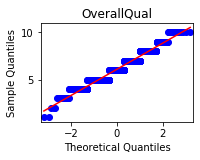

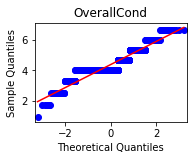

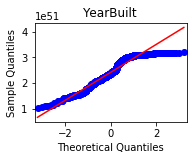

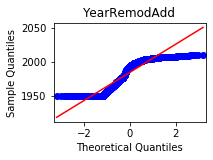

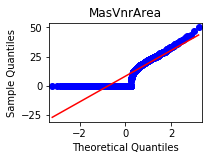

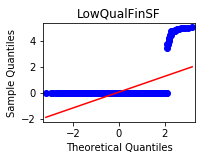

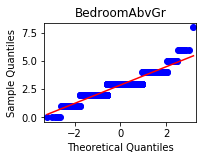

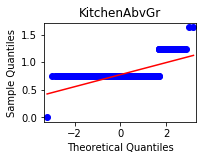

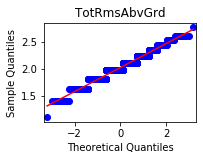

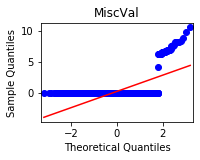

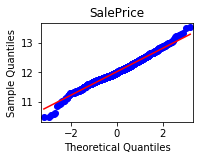

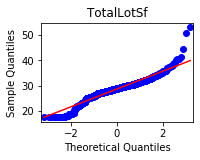

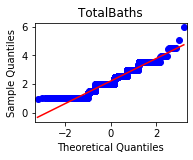

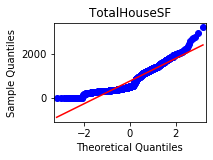

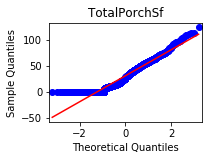

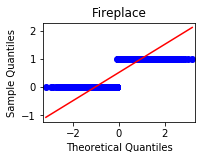

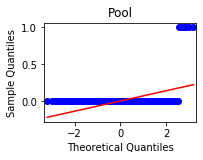

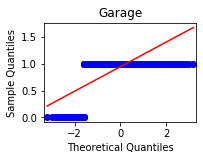

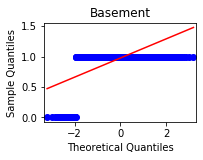

In [69]:
numgraph = ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'MiscVal', 'SalePrice','TotalLotSf', 'TotalBaths',
       'TotalHouseSF', 'TotalPorchSf', 'Fireplace', 'Pool', 'Garage',
       'Basement']

for x in numgraph:
    qqplot(train_edits[x], line='s', ax = plt.subplot(222))
    plt.title(label=x)
    plt.show() 

Columns that are not normally distributed (not counting the categorical values): MiscVal, KitchenAbvGr, LowQualFinSF, MasVnrArea and YearRemodAdd

## Look for corelation to sale price

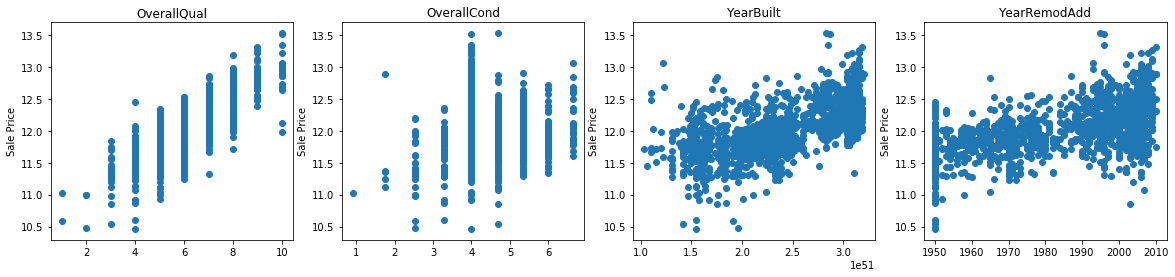

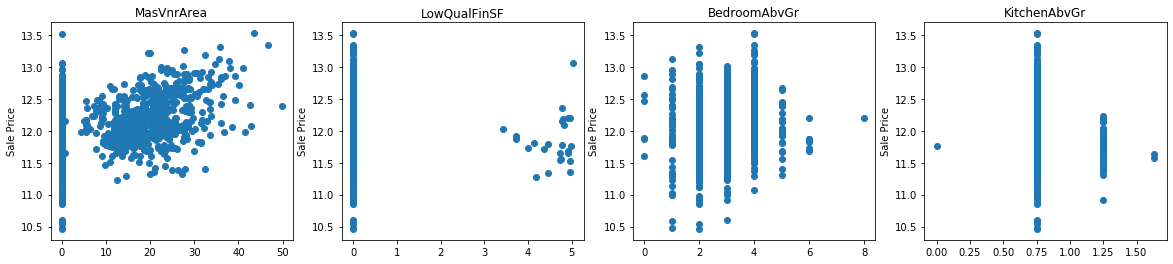

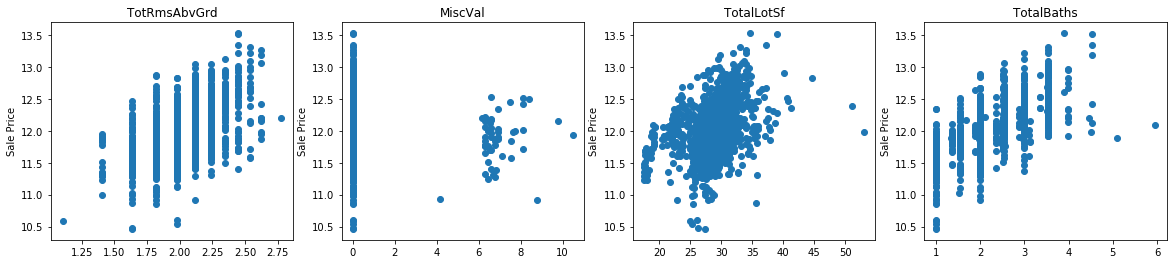

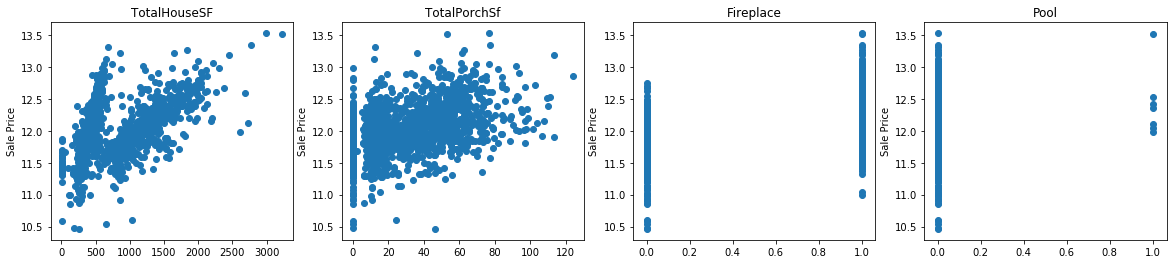

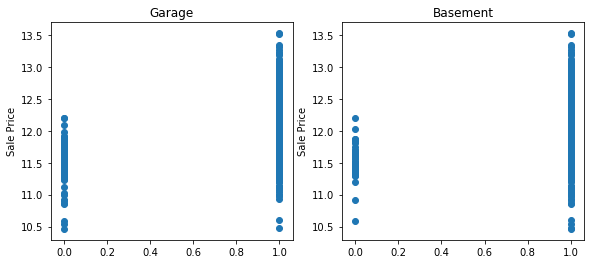

In [70]:
numgraph = ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'LowQualFinSF', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'MiscVal', 'TotalLotSf', 'TotalBaths',
       'TotalHouseSF', 'TotalPorchSf', 'Fireplace', 'Pool', 'Garage',
       'Basement']
count = 0
for x in numgraph:
    plt.figure(count//4,figsize=(20,4))
    plt.subplot(1,4,np.mod(count,4)+1)
    plt.scatter(train_edits[x], y_train)
    plt.title(label=x)
    plt.ylabel('Sale Price')
    count += 1
plt.show() 

Based on these 2 comparisons, we decided to remove these specific columns:

MiscVal, KitchenAbvGr, LowQualFinSF, MasVnrArea and YearRemodAdd

In [71]:
print('Number of columns before: ', len(train_edits.columns))
train_edits = train_edits.drop(['MiscVal', 'KitchenAbvGr', 'LowQualFinSF', 'MasVnrArea', 'YearRemodAdd'], axis=1)

test_edits = test_edits.drop(['MiscVal', 'KitchenAbvGr', 'LowQualFinSF', 'MasVnrArea', 'YearRemodAdd'], axis=1)
print('Number of columns after: ', len(train_edits.columns))
combined_edits = [train_edits, test_edits]

Number of columns before:  66
Number of columns after:  61


In [72]:
train_edits.head()

,Id,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleCondition,SalePrice,TotalLotSf,TotalBaths,TotalHouseSF,TotalPorchSf,Fireplace,Pool,Garage,Basement
0,1,60,RL,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,...,Normal,12.247699,28.120267,3.527460,1321.691404,12.009558,0,0,1,1
1,2,20,RL,Pave,0,Reg,Lvl,AllPub,FR2,Gtl,...,Normal,12.109016,30.227802,2.355405,412.852987,56.339208,1,0,1,1
2,3,60,RL,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,...,Normal,12.317171,29.112546,3.527460,1354.473450,9.849185,1,0,1,1
3,4,70,RL,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,...,Abnorml,11.849405,27.721971,1.992784,1172.823080,24.933771,1,0,1,1
4,5,60,RL,Pave,0,IR1,Lvl,AllPub,FR2,Gtl,...,Normal,12.429220,31.544600,3.527460,1646.920051,56.531530,1,0,1,1


# We are done with the numerical columns let's move on to the object type columns

In [73]:
categorical.columns.values

array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition'], dtype=object)

In [74]:
train_edits['Alley'].unique()

array([0, 'Grvl', 'Pave'], dtype=object)

In [75]:
catgraph = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

for dataset in combined_edits:
    for x in catgraph:
        dataset[x] = dataset[x].apply(str)  

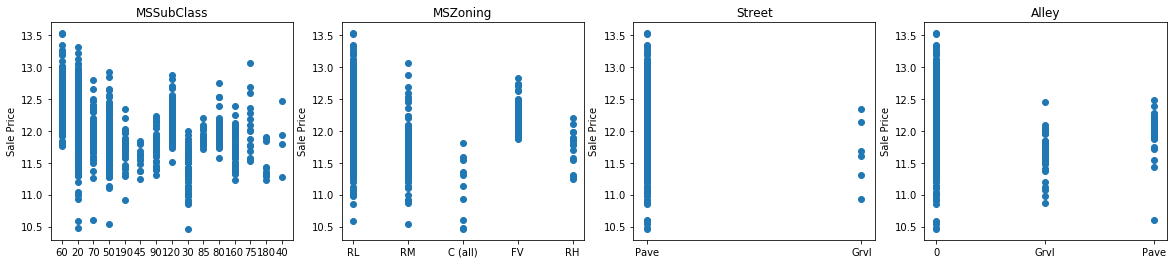

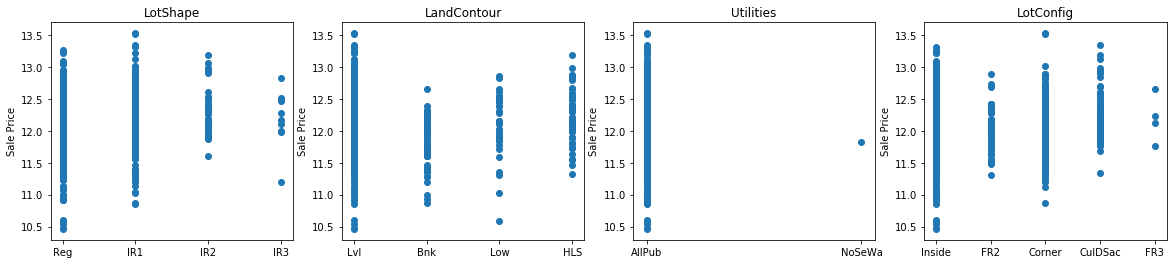

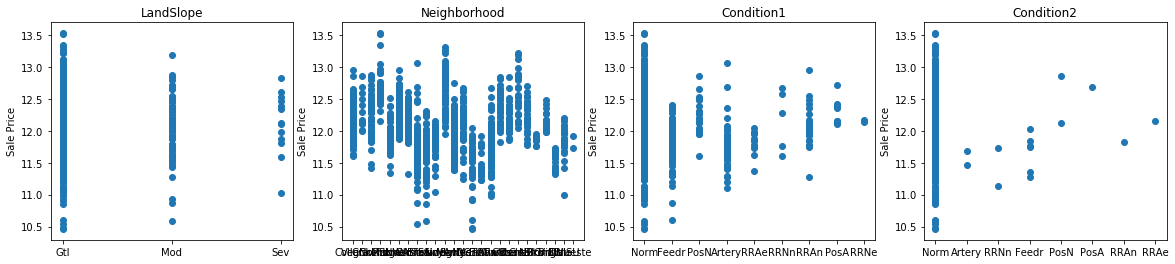

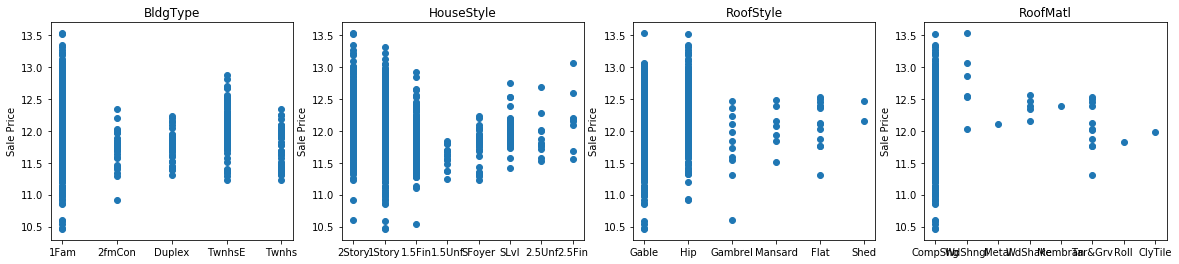

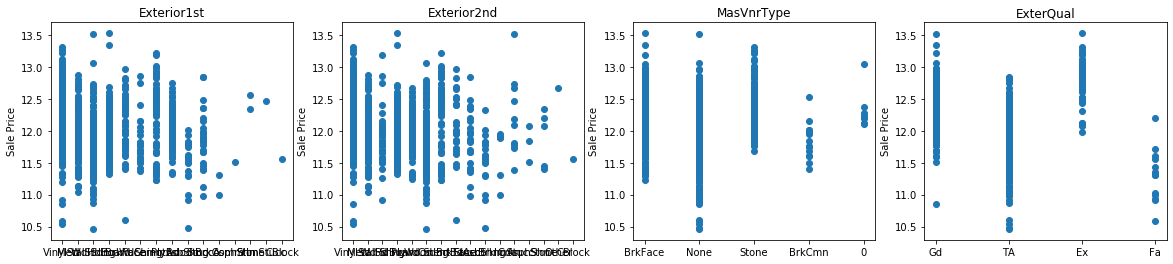

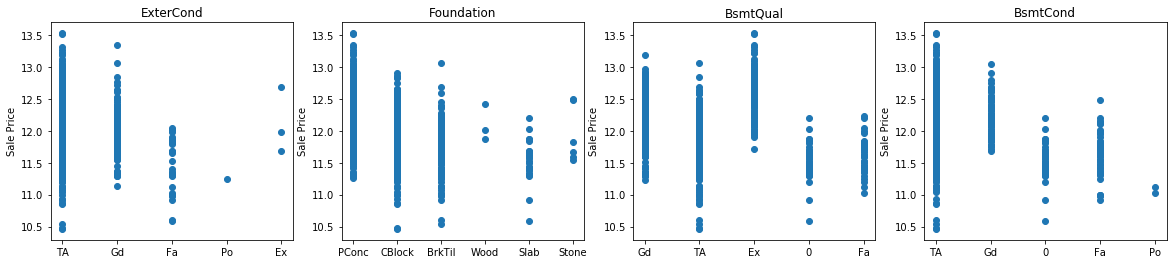

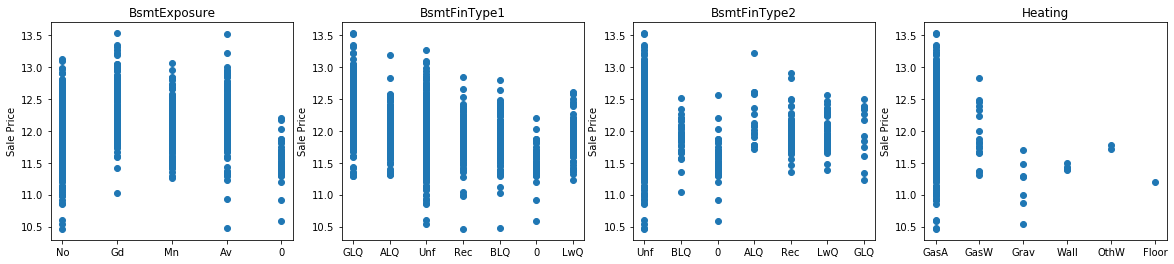

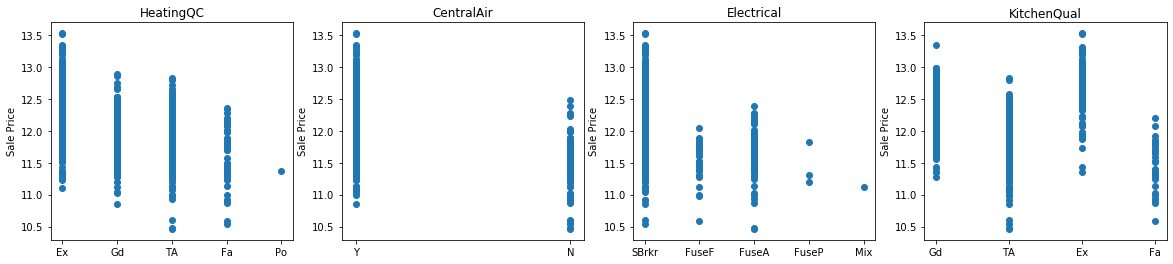

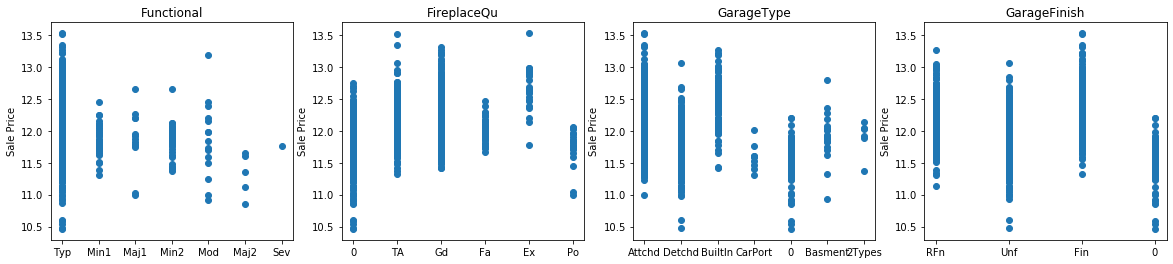

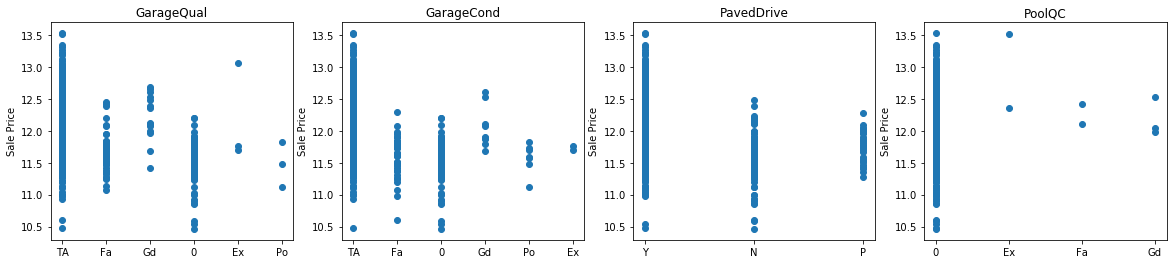

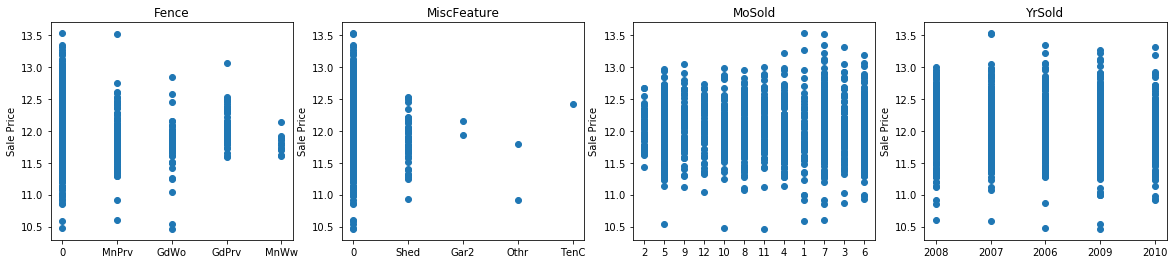

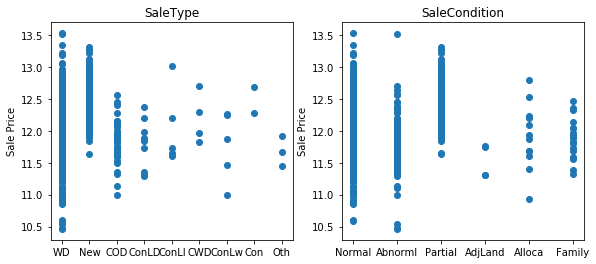

In [76]:
count = 0
for x in catgraph:
    plt.figure(count//4,figsize=(20,4))
    plt.subplot(1,4,np.mod(count,4)+1)
    plt.scatter(train_edits[x], y_train)
    plt.title(label=x)
    plt.ylabel('Sale Price')
    count += 1
plt.show() 

In [77]:
categorical2 = categorical.copy()
categorical2.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,TA,TA,Y,0,0,0,2,2008,WD,Normal
1,20,RL,Pave,0,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,TA,TA,Y,0,0,0,5,2007,WD,Normal
2,60,RL,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,TA,TA,Y,0,0,0,9,2008,WD,Normal
3,70,RL,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,TA,TA,Y,0,0,0,2,2006,WD,Abnorml
4,60,RL,Pave,0,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,TA,TA,Y,0,0,0,12,2008,WD,Normal


In [78]:
for x in categorical2:
    categorical2[x] = categorical2[x].apply(str)  

In [79]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()
categorical3 = categorical2.apply(LabelEncoder().fit_transform)
categorical3.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,10,3,1,0,3,3,1,4,0,5,...,5,5,2,0,0,0,4,2,8,4
1,5,3,1,0,3,3,1,2,0,24,...,5,5,2,0,0,0,7,1,8,4
2,10,3,1,0,0,3,1,4,0,5,...,5,5,2,0,0,0,11,2,8,4
3,11,3,1,0,0,3,1,0,0,6,...,5,5,2,0,0,0,4,0,8,0
4,10,3,1,0,0,3,1,2,0,15,...,5,5,2,0,0,0,3,2,8,4


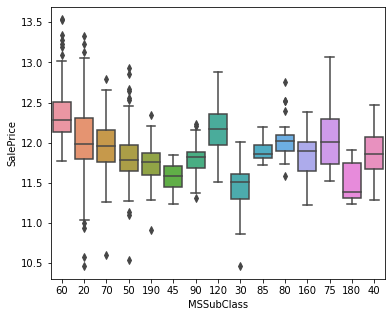

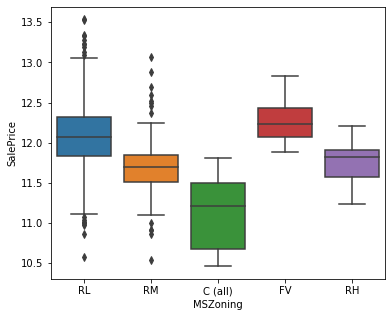

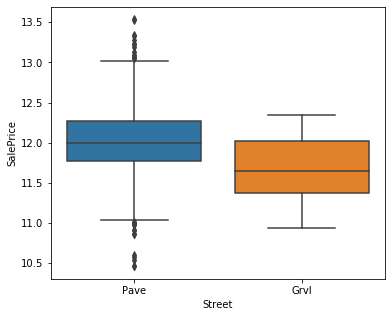

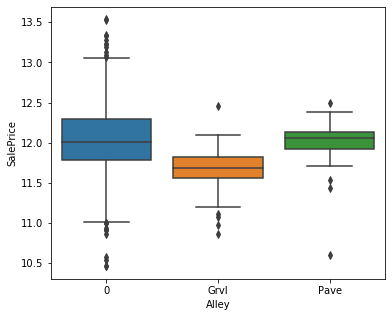

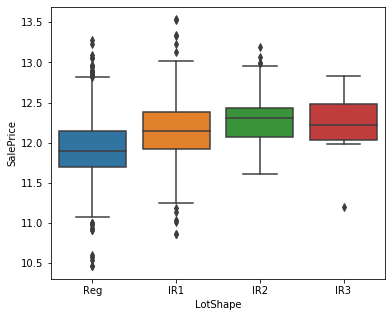

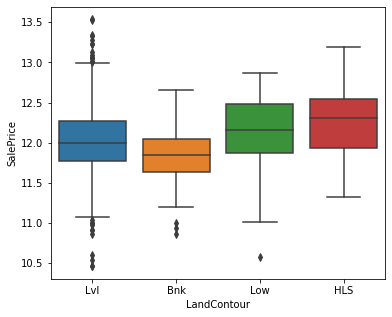

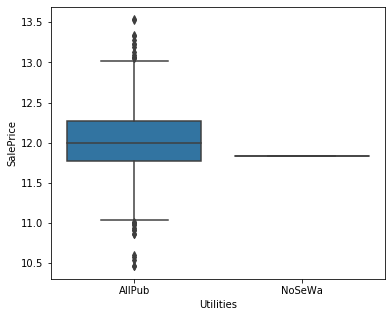

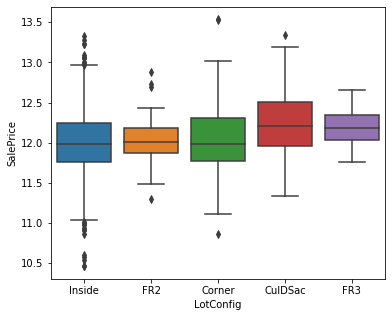

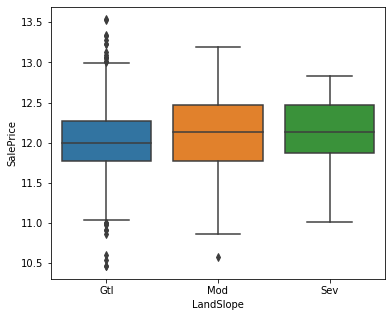

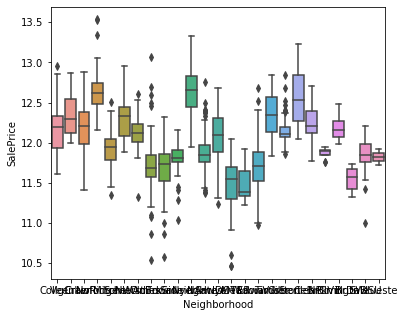

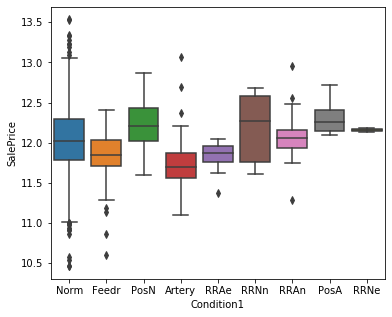

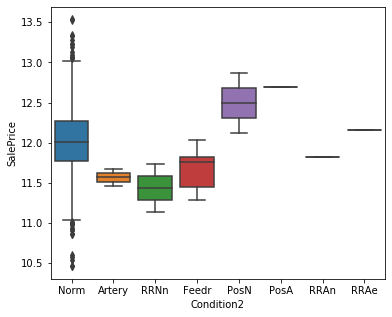

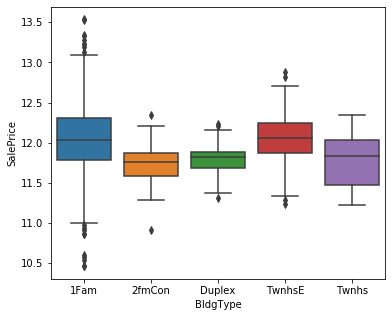

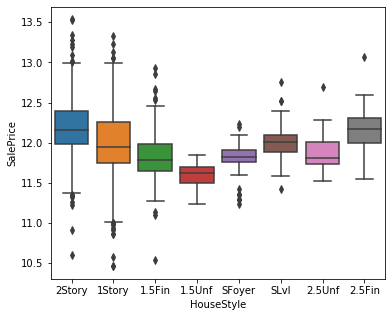

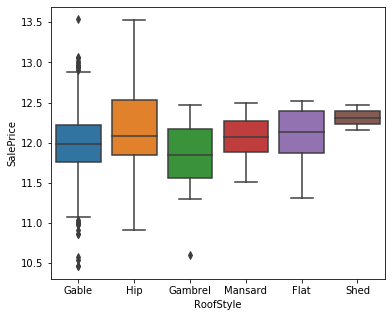

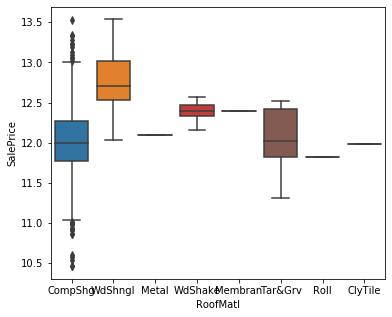

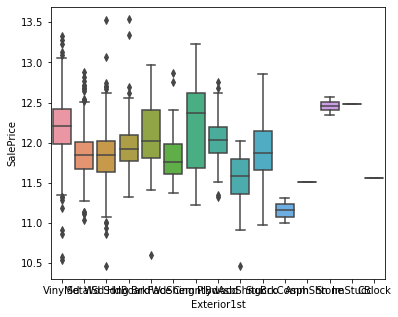

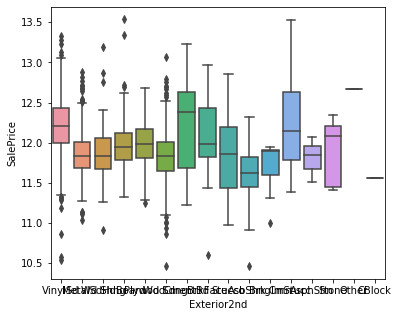

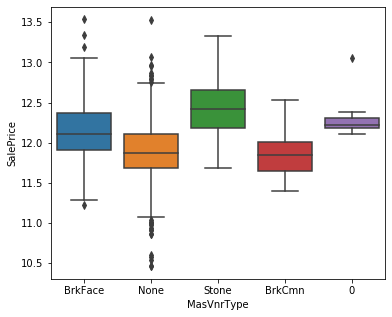

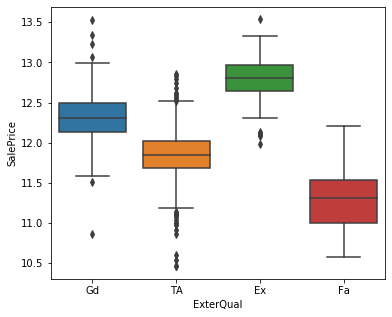

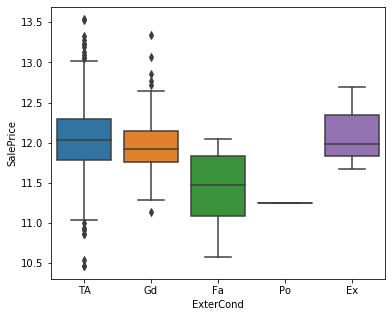

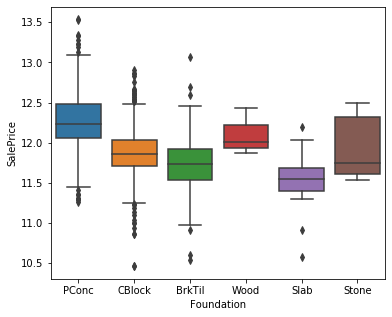

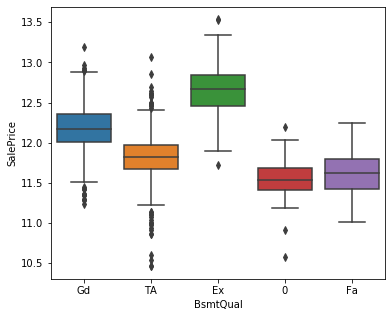

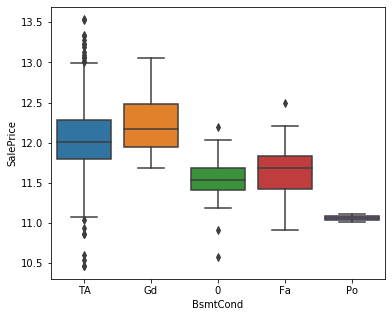

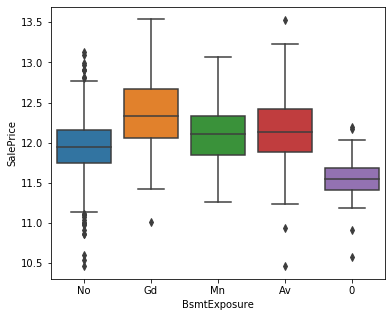

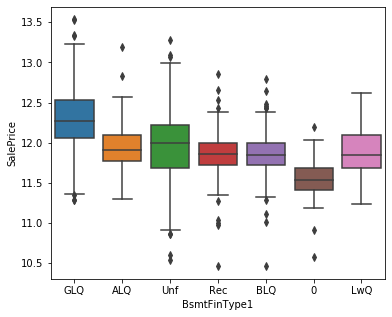

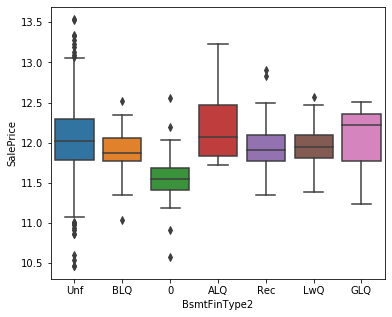

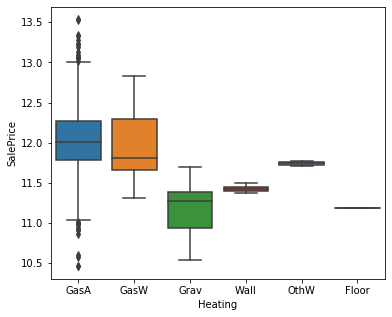

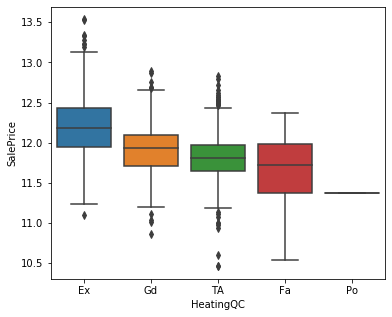

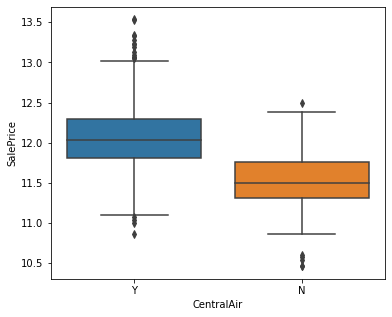

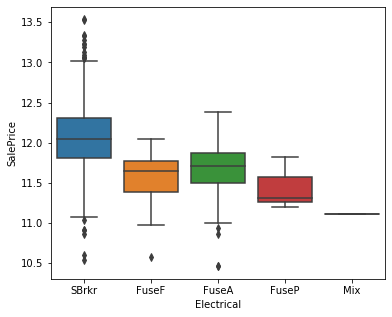

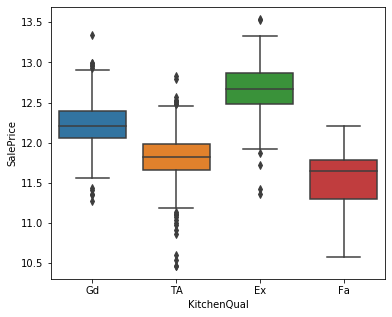

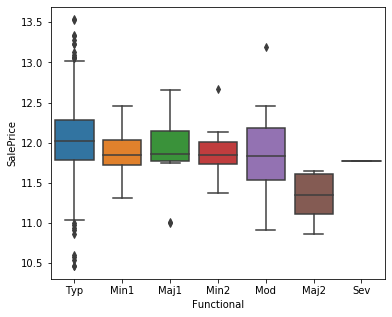

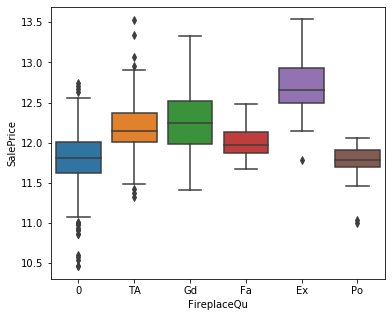

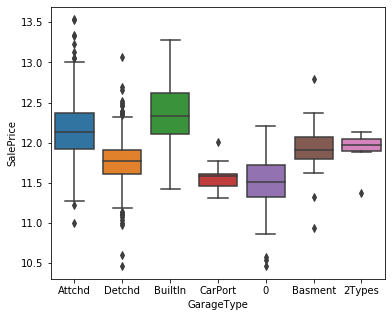

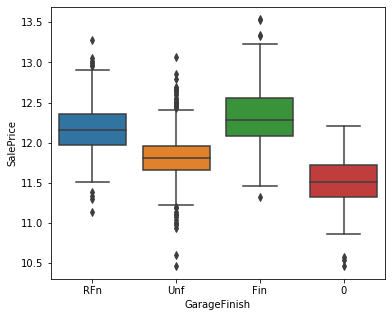

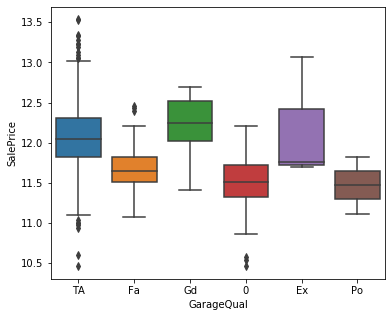

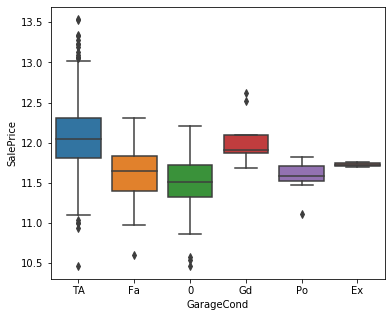

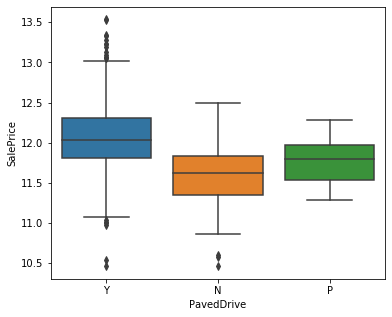

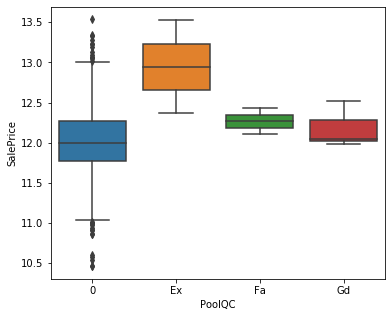

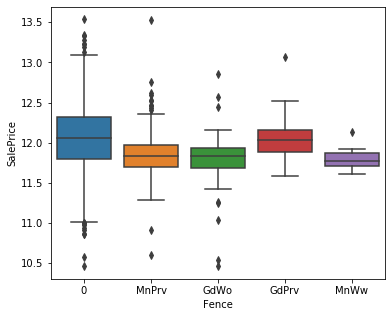

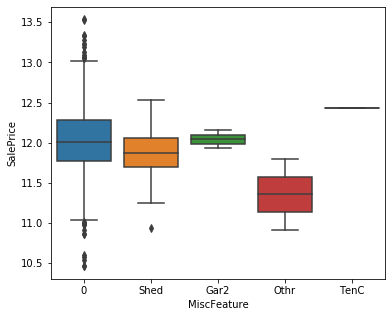

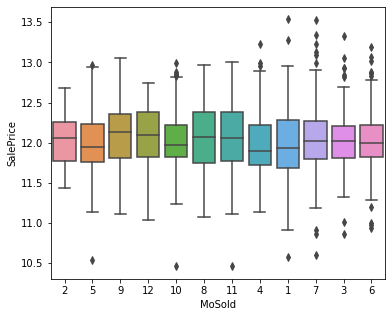

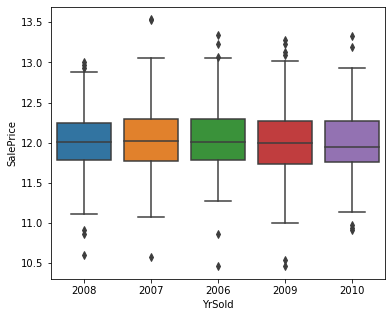

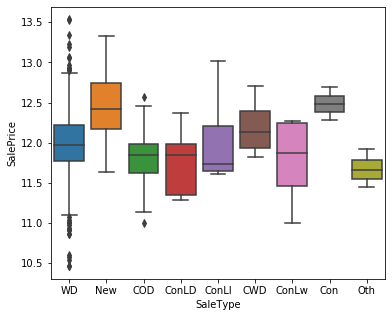

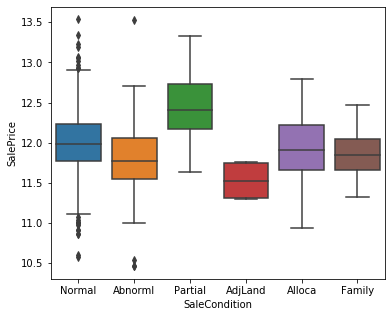

In [80]:
import warnings
warnings.filterwarnings('ignore')

count = 0
for x in catgraph:
    data = pd.concat([train_edits['SalePrice'], train_edits[x]], axis=1)
    f, ax = plt.subplots(figsize=(6, 5))
    fig = sns.boxplot(x=x, y="SalePrice", data=data)
    count += 1
plt.show()  

In [81]:
print('Number of columns before: ', len(train_edits.columns))
train_edits = train_edits.drop(['MiscFeature'], axis=1)

test_edits = test_edits.drop(['MiscFeature'], axis=1)
print('Number of columns after: ', len(train_edits.columns))
combined_edits = [train_edits, test_edits]

Number of columns before:  61
Number of columns after:  60


In [82]:
train_edits.head()

,Id,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleCondition,SalePrice,TotalLotSf,TotalBaths,TotalHouseSF,TotalPorchSf,Fireplace,Pool,Garage,Basement
0,1,60,RL,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,...,Normal,12.247699,28.120267,3.527460,1321.691404,12.009558,0,0,1,1
1,2,20,RL,Pave,0,Reg,Lvl,AllPub,FR2,Gtl,...,Normal,12.109016,30.227802,2.355405,412.852987,56.339208,1,0,1,1
2,3,60,RL,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,...,Normal,12.317171,29.112546,3.527460,1354.473450,9.849185,1,0,1,1
3,4,70,RL,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,...,Abnorml,11.849405,27.721971,1.992784,1172.823080,24.933771,1,0,1,1
4,5,60,RL,Pave,0,IR1,Lvl,AllPub,FR2,Gtl,...,Normal,12.429220,31.544600,3.527460,1646.920051,56.531530,1,0,1,1


In [83]:
#categorical3 = categorical2.apply(LabelEncoder().fit_transform)
categorical3 = categorical3.drop(['MiscFeature'], axis=1)
categorical3.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition
0,10,3,1,0,3,3,1,4,0,5,...,2,5,5,2,0,0,4,2,8,4
1,5,3,1,0,3,3,1,2,0,24,...,2,5,5,2,0,0,7,1,8,4
2,10,3,1,0,0,3,1,4,0,5,...,2,5,5,2,0,0,11,2,8,4
3,11,3,1,0,0,3,1,0,0,6,...,3,5,5,2,0,0,4,0,8,0
4,10,3,1,0,0,3,1,2,0,15,...,2,5,5,2,0,0,3,2,8,4


In [84]:
cat_edit = categorical3.columns
cat_edit

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'],
      dtype='object')

In [85]:
cat_edits = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
  
for dataset in combined_edits:
    for x in cat_edits:
        dataset[x] = dataset[x].apply(str)

test_ids = test_edits['Id']       
train_edits = train_edits.drop(['Id'], axis=1) 
test_edits = test_edits.drop(['Id'], axis=1) 

train_edits = train_edits.apply(LabelEncoder().fit_transform)
test_edits = train_edits.apply(LabelEncoder().fit_transform)
combined_edits= [train_edits,test_edits]

In [86]:
train_edits.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,SaleCondition,SalePrice,TotalLotSf,TotalBaths,TotalHouseSF,TotalPorchSf,Fireplace,Pool,Garage,Basement
0,9,3,1,0,3,3,0,4,0,5,...,4,412,391,28,1012,71,0,0,1,1
1,4,3,1,0,3,3,0,2,0,24,...,4,339,796,13,377,669,1,0,1,1
2,9,3,1,0,0,3,0,4,0,5,...,4,442,564,28,1030,37,1,0,1,1
3,10,3,1,0,0,3,0,0,0,6,...,0,194,319,9,905,267,1,0,1,1
4,9,3,1,0,0,3,0,2,0,15,...,4,494,969,28,1157,673,1,0,1,1


## Co-relation

In [87]:
co_relation=pd.DataFrame(train_edits.corr()["SalePrice"]) 
co_relation

,SalePrice
MSSubClass,0.058884
MSZoning,-0.231544
Street,0.043856
Alley,-0.085927
LotShape,-0.295262
LandContour,0.023508
Utilities,-0.017102
LotConfig,-0.069740
LandSlope,0.057289
Neighborhood,0.189857


# Linear Regression viewing with statsmodels before actual modeling

In [88]:
trainstats = train_edits.copy()
teststats = test_edits.copy()

In [89]:
import statsmodels.api as sm
xstats = trainstats.drop("SalePrice", axis = 1).values
ystats = teststats.loc[:,'SalePrice'].values

In [90]:
x1 = sm.add_constant(xstats)
results = sm.OLS(ystats,x1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     168.8
Date:                Thu, 19 Aug 2021   Prob (F-statistic):               0.00
Time:                        19:41:11   Log-Likelihood:                -8050.3
No. Observations:                1460   AIC:                         1.622e+04
Df Residuals:                    1401   BIC:                         1.653e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -217.7842     42.770     -5.092      0.000    -301.684    -133.884
x1            -0.8206      0.716     -1.147      0.252      -2.224       0.583
x2           -11.8778      2.959     -4.014      0.000     -17.682      -6.073
x3            58.4835     26.533      2.204      0.028       6.435     110.532
x4             7.9140      4.985      1.588      0.113      -1.865      17.693
x5            -4.0057      1.270     -3.153      0.002      -6.498      -1.514
x6             2.4885      2.583      0.963      0.336      -2.579       7.556
x7           -65.6818     63.318     -1.037      0.300    -189.890      58.526
x8            -0.6336      1.051     -0.603      0.547      -2.696       1.429
x9            30.5472      6.880      4.440      0.000      17.052      44.043
x10            0.2466      0.298      0.828      0.408      -0.338       0.831
x11            2.1247      1.935      1.098      0.272      -1.671       5.920
x12           -9.5350      6.377     -1.495      0.135     -22.044       2.974
x13           -7.2604      1.878     -3.866      0.000     -10.945      -3.576
x14           -6.0734      1.140     -5.327      0.000      -8.310      -3.837
x15           34.0325      2.192     15.529      0.000      29.733      38.332
x16           13.5878      1.832      7.418      0.000       9.995      17.181
x17            0.8486      0.133      6.399      0.000       0.588       1.109
x18            3.5507      2.111      1.682      0.093      -0.591       7.692
x19            6.6564      2.830      2.352      0.019       1.105      12.208
x20           -3.0759      0.995     -3.090      0.002      -5.028      -1.123
x21            2.3575      0.902      2.614      0.009       0.588       4.127
x22           -0.9192      2.659     -0.346      0.730      -6.135       4.296
x23           -6.5914      3.744     -1.761      0.079     -13.935       0.752
x24            0.4551      2.405      0.189      0.850      -4.263       5.173
x25            5.5125      3.283      1.679      0.093      -0.927      11.952
x26           -6.7060      2.781     -2.412      0.016     -12.161      -1.251
x27           -0.6402      2.637     -0.243      0.808      -5.813       4.533
x28           -6.7424      1.708     -3.948      0.000     -10.092      -3.393
x29           -2.7266      1.068     -2.553      0.011      -4.822      -0.632
x30           -0.8664      1.813     -0.478      0.633      -4.422       2.689
x31           -1.1017      6.196     -0.178      0.859     -13.257      11.053
x32           -4.6113      1.168     -3.950      0.000      -6.902      -2.321
x33            1.1429      8.528      0.134      0.893     -15.586      17.872
x34           -0.8066      1.751     -0.461      0.645      -4.242       2.629
x35           -6.0807      3.133     -1.941      0.052     -12.226       0.065
x3

# Finalize data before model training

In [91]:
Data = pd.concat((train_edits, test_edits)).reset_index(drop=True)
Data.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,SaleCondition,SalePrice,TotalLotSf,TotalBaths,TotalHouseSF,TotalPorchSf,Fireplace,Pool,Garage,Basement
0,9,3,1,0,3,3,0,4,0,5,...,4,412,391,28,1012,71,0,0,1,1
1,4,3,1,0,3,3,0,2,0,24,...,4,339,796,13,377,669,1,0,1,1
2,9,3,1,0,0,3,0,4,0,5,...,4,442,564,28,1030,37,1,0,1,1
3,10,3,1,0,0,3,0,0,0,6,...,0,194,319,9,905,267,1,0,1,1
4,9,3,1,0,0,3,0,2,0,15,...,4,494,969,28,1157,673,1,0,1,1


In [92]:
Data = Data.drop("SalePrice", axis = 1)
final_data = pd.get_dummies(Data)

In [93]:
#y = y_train 
Y = y_og
X = final_data.iloc[:len(y_train), :] #train
X_test = final_data.iloc[1461:, :] #test

# Training models

In [94]:
def predict(ml):          
    model = ml.fit(X,Y)
    print('Score : {}'.format(model.score(X,Y)))
    global y_pred
    y_pred = model.predict(X_test)

# Linear regression

In [95]:
from sklearn.linear_model import LinearRegression
predict(LinearRegression())

LR = y_pred
LR

Score : 0.8251518219641635


array([210643.98467214, 222650.54958189, 159063.23426731, ...,
       238523.88980174, 149939.53531754, 164889.26278031])

# Random forest

In [432]:
from sklearn.ensemble import RandomForestRegressor
predict(RandomForestRegressor(ccp_alpha=.001,n_estimators=95, max_depth = 55))

RF = y_pred
RF

Score : 0.9760637435231608


array([177617.23157895, 221087.14736842, 151325.78947368, ...,
       247802.21052632, 142613.15789474, 150886.31578947])

# GradientBoosting

In [420]:
from sklearn.ensemble import GradientBoostingRegressor
predict(GradientBoostingRegressor(n_estimators=1200, min_samples_split = 3, min_samples_leaf=2, loss='huber'))

GBR = y_pred
GBR

Score : 0.9897085222462668


array([181353.25473948, 221895.76967636, 143766.80747107, ...,
       265250.51749947, 142248.98708775, 148601.50732459])

# Lasso

In [327]:
from sklearn.linear_model import Lasso
predict(make_pipeline(RobustScaler(),Lasso(max_iter=100,alpha=.05, normalize=True)))

Lasso = y_pred
Lasso

Score : 0.8251517232990199


array([210630.74693368, 222663.33926833, 159069.2747442 , ...,
       238531.15000916, 149931.70187345, 164899.06218818])

# Ridge

In [358]:
from sklearn.linear_model import Ridge
predict(Ridge(solver='auto',alpha=.0001,  max_iter=200, normalize = True, random_state = 5))

Ridge = y_pred
Ridge

Score : 0.8251517990643888


array([210643.70830948, 222658.4190086 , 159066.67749229, ...,
       238521.96831212, 149940.87498071, 164891.09162617])

# K Neighbors

In [370]:
from sklearn.neighbors import KNeighborsRegressor
predict(KNeighborsRegressor(n_neighbors=2,
    weights='uniform',
    algorithm='ball_tree',
    leaf_size=40,
    p=1,
    metric='minkowski',
    metric_params=None,))

KN = y_pred
KN

Score : 0.8733067713730691


array([160250. , 217250. , 134000. , ..., 206200. , 148062.5, 156250. ])

# Decision tree

In [376]:
from sklearn.tree import DecisionTreeRegressor
predict(DecisionTreeRegressor(criterion='mse',max_depth=13,random_state=10))

DT = y_pred
DT

Score : 0.9925382889849702


array([180700.        , 221725.        , 140000.        , ...,
       266500.        , 140499.02941176, 147500.        ])

In [419]:
from catboost import CatBoostRegressor,Pool
predict(CatBoostRegressor(iterations=2000, learning_rate=.055, eval_metric='AUC',))
CBR = y_pred
CBR

0:	total: 7.22ms	remaining: 14.4s
1:	total: 10.2ms	remaining: 10.2s
2:	total: 13.1ms	remaining: 8.75s
3:	total: 15.8ms	remaining: 7.86s
4:	total: 18.5ms	remaining: 7.37s
5:	total: 21.4ms	remaining: 7.12s
6:	total: 24.2ms	remaining: 6.88s
7:	total: 26.9ms	remaining: 6.7s
8:	total: 29.7ms	remaining: 6.57s
9:	total: 32.5ms	remaining: 6.47s
10:	total: 35.3ms	remaining: 6.39s
11:	total: 38.1ms	remaining: 6.31s
12:	total: 40.8ms	remaining: 6.23s
13:	total: 43.4ms	remaining: 6.15s
14:	total: 46.5ms	remaining: 6.16s
15:	total: 50.1ms	remaining: 6.21s
16:	total: 53.9ms	remaining: 6.29s
17:	total: 56.8ms	remaining: 6.25s
18:	total: 59.4ms	remaining: 6.2s
19:	total: 61.8ms	remaining: 6.12s
20:	total: 64.2ms	remaining: 6.05s
21:	total: 66.9ms	remaining: 6.01s
22:	total: 69.7ms	remaining: 5.99s
23:	total: 72.5ms	remaining: 5.97s
24:	total: 75.5ms	remaining: 5.96s
25:	total: 78.8ms	remaining: 5.98s
26:	total: 82ms	remaining: 5.99s
27:	total: 84.9ms	remaining: 5.98s
28:	total: 87.4ms	remaining: 5.94s

284:	total: 705ms	remaining: 4.24s
285:	total: 707ms	remaining: 4.24s
286:	total: 710ms	remaining: 4.24s
287:	total: 712ms	remaining: 4.23s
288:	total: 715ms	remaining: 4.23s
289:	total: 717ms	remaining: 4.23s
290:	total: 720ms	remaining: 4.23s
291:	total: 722ms	remaining: 4.22s
292:	total: 725ms	remaining: 4.22s
293:	total: 728ms	remaining: 4.22s
294:	total: 730ms	remaining: 4.22s
295:	total: 733ms	remaining: 4.22s
296:	total: 736ms	remaining: 4.22s
297:	total: 739ms	remaining: 4.22s
298:	total: 742ms	remaining: 4.22s
299:	total: 745ms	remaining: 4.22s
300:	total: 747ms	remaining: 4.22s
301:	total: 749ms	remaining: 4.21s
302:	total: 752ms	remaining: 4.21s
303:	total: 754ms	remaining: 4.21s
304:	total: 756ms	remaining: 4.2s
305:	total: 759ms	remaining: 4.2s
306:	total: 761ms	remaining: 4.2s
307:	total: 764ms	remaining: 4.2s
308:	total: 767ms	remaining: 4.2s
309:	total: 770ms	remaining: 4.2s
310:	total: 772ms	remaining: 4.19s
311:	total: 775ms	remaining: 4.19s
312:	total: 778ms	remainin

537:	total: 1.41s	remaining: 3.82s
538:	total: 1.41s	remaining: 3.82s
539:	total: 1.41s	remaining: 3.81s
540:	total: 1.41s	remaining: 3.81s
541:	total: 1.42s	remaining: 3.81s
542:	total: 1.42s	remaining: 3.81s
543:	total: 1.42s	remaining: 3.8s
544:	total: 1.42s	remaining: 3.8s
545:	total: 1.43s	remaining: 3.8s
546:	total: 1.43s	remaining: 3.79s
547:	total: 1.43s	remaining: 3.79s
548:	total: 1.43s	remaining: 3.79s
549:	total: 1.44s	remaining: 3.79s
550:	total: 1.44s	remaining: 3.78s
551:	total: 1.46s	remaining: 3.82s
552:	total: 1.46s	remaining: 3.82s
553:	total: 1.46s	remaining: 3.81s
554:	total: 1.46s	remaining: 3.81s
555:	total: 1.47s	remaining: 3.81s
556:	total: 1.47s	remaining: 3.81s
557:	total: 1.47s	remaining: 3.8s
558:	total: 1.47s	remaining: 3.8s
559:	total: 1.48s	remaining: 3.79s
560:	total: 1.48s	remaining: 3.79s
561:	total: 1.48s	remaining: 3.79s
562:	total: 1.48s	remaining: 3.79s
563:	total: 1.49s	remaining: 3.78s
564:	total: 1.49s	remaining: 3.78s
565:	total: 1.49s	remaini

839:	total: 2.3s	remaining: 3.17s
840:	total: 2.3s	remaining: 3.17s
841:	total: 2.3s	remaining: 3.17s
842:	total: 2.31s	remaining: 3.17s
843:	total: 2.31s	remaining: 3.16s
844:	total: 2.31s	remaining: 3.16s
845:	total: 2.31s	remaining: 3.16s
846:	total: 2.32s	remaining: 3.15s
847:	total: 2.32s	remaining: 3.15s
848:	total: 2.32s	remaining: 3.15s
849:	total: 2.32s	remaining: 3.14s
850:	total: 2.33s	remaining: 3.14s
851:	total: 2.33s	remaining: 3.14s
852:	total: 2.33s	remaining: 3.14s
853:	total: 2.33s	remaining: 3.13s
854:	total: 2.34s	remaining: 3.13s
855:	total: 2.34s	remaining: 3.13s
856:	total: 2.34s	remaining: 3.12s
857:	total: 2.34s	remaining: 3.12s
858:	total: 2.35s	remaining: 3.12s
859:	total: 2.35s	remaining: 3.12s
860:	total: 2.35s	remaining: 3.11s
861:	total: 2.35s	remaining: 3.11s
862:	total: 2.36s	remaining: 3.1s
863:	total: 2.36s	remaining: 3.1s
864:	total: 2.36s	remaining: 3.1s
865:	total: 2.36s	remaining: 3.1s
866:	total: 2.37s	remaining: 3.09s
867:	total: 2.37s	remaining

1132:	total: 3.01s	remaining: 2.3s
1133:	total: 3.01s	remaining: 2.3s
1134:	total: 3.02s	remaining: 2.3s
1135:	total: 3.02s	remaining: 2.29s
1136:	total: 3.02s	remaining: 2.29s
1137:	total: 3.02s	remaining: 2.29s
1138:	total: 3.03s	remaining: 2.29s
1139:	total: 3.03s	remaining: 2.29s
1140:	total: 3.03s	remaining: 2.28s
1141:	total: 3.03s	remaining: 2.28s
1142:	total: 3.04s	remaining: 2.28s
1143:	total: 3.04s	remaining: 2.27s
1144:	total: 3.04s	remaining: 2.27s
1145:	total: 3.04s	remaining: 2.27s
1146:	total: 3.05s	remaining: 2.27s
1147:	total: 3.05s	remaining: 2.26s
1148:	total: 3.05s	remaining: 2.26s
1149:	total: 3.06s	remaining: 2.26s
1150:	total: 3.06s	remaining: 2.26s
1151:	total: 3.06s	remaining: 2.25s
1152:	total: 3.07s	remaining: 2.25s
1153:	total: 3.07s	remaining: 2.25s
1154:	total: 3.07s	remaining: 2.25s
1155:	total: 3.08s	remaining: 2.25s
1156:	total: 3.08s	remaining: 2.24s
1157:	total: 3.08s	remaining: 2.24s
1158:	total: 3.08s	remaining: 2.24s
1159:	total: 3.09s	remaining: 2

1402:	total: 3.71s	remaining: 1.58s
1403:	total: 3.71s	remaining: 1.58s
1404:	total: 3.72s	remaining: 1.57s
1405:	total: 3.72s	remaining: 1.57s
1406:	total: 3.72s	remaining: 1.57s
1407:	total: 3.73s	remaining: 1.57s
1408:	total: 3.73s	remaining: 1.56s
1409:	total: 3.73s	remaining: 1.56s
1410:	total: 3.73s	remaining: 1.56s
1411:	total: 3.74s	remaining: 1.56s
1412:	total: 3.74s	remaining: 1.55s
1413:	total: 3.74s	remaining: 1.55s
1414:	total: 3.74s	remaining: 1.55s
1415:	total: 3.75s	remaining: 1.54s
1416:	total: 3.75s	remaining: 1.54s
1417:	total: 3.75s	remaining: 1.54s
1418:	total: 3.75s	remaining: 1.54s
1419:	total: 3.76s	remaining: 1.53s
1420:	total: 3.76s	remaining: 1.53s
1421:	total: 3.76s	remaining: 1.53s
1422:	total: 3.76s	remaining: 1.53s
1423:	total: 3.77s	remaining: 1.52s
1424:	total: 3.77s	remaining: 1.52s
1425:	total: 3.77s	remaining: 1.52s
1426:	total: 3.77s	remaining: 1.51s
1427:	total: 3.78s	remaining: 1.51s
1428:	total: 3.78s	remaining: 1.51s
1429:	total: 3.78s	remaining

1679:	total: 4.42s	remaining: 842ms
1680:	total: 4.42s	remaining: 839ms
1681:	total: 4.42s	remaining: 837ms
1682:	total: 4.43s	remaining: 834ms
1683:	total: 4.43s	remaining: 831ms
1684:	total: 4.43s	remaining: 829ms
1685:	total: 4.43s	remaining: 826ms
1686:	total: 4.44s	remaining: 823ms
1687:	total: 4.44s	remaining: 821ms
1688:	total: 4.44s	remaining: 818ms
1689:	total: 4.45s	remaining: 816ms
1690:	total: 4.45s	remaining: 813ms
1691:	total: 4.45s	remaining: 810ms
1692:	total: 4.45s	remaining: 808ms
1693:	total: 4.46s	remaining: 805ms
1694:	total: 4.46s	remaining: 802ms
1695:	total: 4.46s	remaining: 800ms
1696:	total: 4.46s	remaining: 797ms
1697:	total: 4.46s	remaining: 794ms
1698:	total: 4.47s	remaining: 792ms
1699:	total: 4.47s	remaining: 789ms
1700:	total: 4.47s	remaining: 786ms
1701:	total: 4.47s	remaining: 783ms
1702:	total: 4.49s	remaining: 783ms
1703:	total: 4.49s	remaining: 781ms
1704:	total: 4.5s	remaining: 778ms
1705:	total: 4.5s	remaining: 775ms
1706:	total: 4.5s	remaining: 7

1957:	total: 5.13s	remaining: 110ms
1958:	total: 5.13s	remaining: 107ms
1959:	total: 5.13s	remaining: 105ms
1960:	total: 5.13s	remaining: 102ms
1961:	total: 5.14s	remaining: 99.5ms
1962:	total: 5.14s	remaining: 96.9ms
1963:	total: 5.14s	remaining: 94.3ms
1964:	total: 5.14s	remaining: 91.6ms
1965:	total: 5.15s	remaining: 89ms
1966:	total: 5.15s	remaining: 86.4ms
1967:	total: 5.15s	remaining: 83.8ms
1968:	total: 5.16s	remaining: 81.2ms
1969:	total: 5.16s	remaining: 78.6ms
1970:	total: 5.16s	remaining: 76ms
1971:	total: 5.16s	remaining: 73.3ms
1972:	total: 5.17s	remaining: 70.7ms
1973:	total: 5.17s	remaining: 68.1ms
1974:	total: 5.17s	remaining: 65.5ms
1975:	total: 5.17s	remaining: 62.9ms
1976:	total: 5.18s	remaining: 60.2ms
1977:	total: 5.18s	remaining: 57.6ms
1978:	total: 5.18s	remaining: 55ms
1979:	total: 5.18s	remaining: 52.4ms
1980:	total: 5.19s	remaining: 49.8ms
1981:	total: 5.19s	remaining: 47.1ms
1982:	total: 5.19s	remaining: 44.5ms
1983:	total: 5.19s	remaining: 41.9ms
1984:	total

array([182919.91319707, 224542.24288846, 142338.32779515, ...,
       265486.68952447, 141381.12637709, 148304.65624461])

In [442]:
import xgboost as xgb
import lightgbm as lgb
predict(xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1))

XGB = y_pred
XGB

[21:12:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Score : 0.9939005777802253


array([183246.11, 220086.48, 144879.42, ..., 261929.42, 142805.4 ,
       152120.92], dtype=float32)

In [449]:
predict(lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.085, n_estimators=2000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11))
LGBM = y_pred
y_pred

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Score : 0.9892508311937493


array([182367.73767755, 221407.83904609, 149776.21286892, ...,
       263944.70071373, 145971.84035315, 145762.19707828])

## After calculating the scores we will rank the models based on accuracy.

1. K neighbors (KN)

2. Decision tree (DT)

3. Random forest (RF)

4. Gradient boosting (GBR)

5. Lasso (Lasso)

6. Ridge (Ridge)

7. Linear regresssion (LR)

In [459]:
final_pred = (DT + GBR + CBR + LGBM + XGB)/5
final_pred

array([182117.40299782, 221931.46719718, 144152.15400203, ...,
       264622.26592253, 142581.27789595, 148457.8565045 ])

In [460]:
submission = pd.DataFrame({
        "Id": test_ids,
        "SalePrice": final_pred
    })
submission.head()
submission.style.hide_index()

Id,SalePrice
1461,182117.402998
1462,221931.467197
1463,144152.154002
1464,263122.861279
1465,145666.986192
1466,302285.802494
1467,199814.161645
1468,128224.417131
1469,117938.870526
1470,130142.717069


In [461]:
submission.to_csv('salesprice_submission.csv', index=False)

Sources: https://www.kaggle.com/shaygu/house-prices-begginer-top-7?scriptVersionId=20339770&select=sample_submission.csv

Huge thanks to: https://www.kaggle.com/shaygu/house-prices-begginer-top-7?scriptVersionId=20339770&select=sample_submission.csv
This notebook is the reason i was able to understand and create a lot of my datascience projects, full credit to him for this notebook!